In [1]:
# Import statements
import os, json, cv2, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import IPython.display as display
from functools import partial
import glob, torch, imagehash
from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5
from tensorflow.keras.mixed_precision import Policy, set_global_policy, LossScaleOptimizer
from tensorflow.keras import layers
import albumentations as A

# Setting seaborn grid style
sns.set_style('darkgrid')

# Selecting 1st GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Mixed Precision
set_global_policy(Policy('mixed_float16'))

# Paths/Data
PATH = "E:\Cassava_images"
IMG_PATH = 'E:\Cassava_images/extraimages/extraimages'
FILENAMES = tf.io.gfile.glob(PATH + "/train_tfrecordsV0_16fold/ld_train*.tfrec")
FILENAMESV3 = tf.io.gfile.glob(PATH + '/train_tfrecordsV2_14fold/Id_train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(PATH + "/test_tfrecords/ld_test*.tfrec")
train = pd.read_csv(os.path.join(PATH, 'trainV1_1.csv'))

# Initialize variables
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3060, compute capability 8.6


Train shape: (27051, 2)


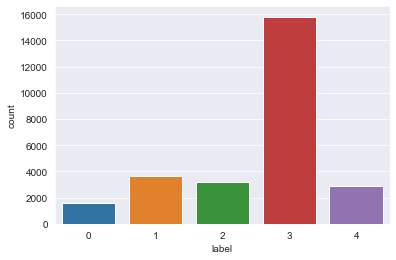

In [5]:
print("Train shape:", train.shape)

sns.countplot(x=train['label'])
plt.show()

# Preprocessing
--> Removing Duplicates

--> Oversampling/Undersampling

--> Stratification

--> Reformulate tfrecord shards

## Removing Duplicates

In [6]:
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for path in tqdm(train['image_id'], desc='Hashing images'):
    image = Image.open(os.path.join(IMG_PATH, path))
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)
hashes_all = torch.Tensor(hashes_all.astype(int))
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).numpy()/256 for i in tqdm(range(hashes_all.shape[0]), desc='Calculating similarities')])

indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}
duplicate_image_ids = sorted(list(dups))
print('Found %d duplicates' % len(duplicate_image_ids))

# Remove duplicates from external data
imgs_to_remove = [x[1] for x in duplicate_image_ids]

Hashing images:   0%|          | 0/27051 [00:00<?, ?it/s]

Calculating similarities:   0%|          | 0/27051 [00:00<?, ?it/s]

Found 721 duplicates


In [26]:
remove_df = pd.DataFrame(duplicate_image_ids)
train_df = train[~train['image_id'].isin(remove_df[1])].reset_index(drop=True)
train_df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
26329,train-healthy-95.jpg,4
26330,train-healthy-96.jpg,4
26331,train-healthy-97.jpg,4
26332,train-healthy-98.jpg,4


## Stratification + Reformulate to shard files

In [12]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [13]:
def serialize_example(feature0, feature1, feature2):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'image': _bytes_feature(feature0),
      'target': _int64_feature(feature1),
      'image_name': _bytes_feature(feature2),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [27]:
# Obtain the multiple of training set size for even splitting
fold_list = []
print('Possible number of folds:')
for n in range(10,20):
    if np.divmod(train_df.shape[0], n)[1]==0:
        print('{} folds - {} images per fold'.format(n, int(train_df.shape[0]/n)))
        fold_list.append(n)

Possible number of folds:
11 folds - 2394 images per fold
14 folds - 1881 images per fold
18 folds - 1463 images per fold
19 folds - 1386 images per fold


In [28]:
N_FILES = fold_list[1]
IMG_QUALITY = 100 # Avoiding 100% Quality as it increases file size
IMAGE_SIZE = [600, 600]
train_df['shard'] = 0

# Stratify the shards
skf = StratifiedKFold(n_splits=N_FILES, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    train_df['shard'].loc[val_idx] = fold

# Rewrite the TFRecords after stratification and resize
for tfrec_num in tqdm(range(N_FILES), desc='Writing TFRecords'):
    samples = train_df[train_df['shard'] == tfrec_num]
    n_samples = len(samples)
    with tf.io.TFRecordWriter('train%ix%i-%.2i-%i.tfrec'%(IMAGE_SIZE[0], IMAGE_SIZE[1], tfrec_num, n_samples)) as writer:
        for row in tqdm(samples.itertuples(), desc=('Fold {}'.format(tfrec_num+1)), total=int(train_df.shape[0]/N_FILES)):
            label = row.label
            image_name = row.image_id
            img_path = os.path.join(IMG_PATH, image_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[0]), interpolation=cv2.INTER_NEAREST)
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tostring()      
            example = serialize_example(img, label, str.encode(image_name))
            writer.write(example)

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Writing TFRecords:   0%|          | 0/14 [00:00<?, ?it/s]

Fold 1:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 2:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 3:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 4:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 5:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 6:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 7:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 8:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 9:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 10:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 11:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 12:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 13:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Fold 14:   0%|          | 0/1881 [00:00<?, ?it/s]

C:\Users\xBaka\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
